<a href="https://colab.research.google.com/github/Sole248k/Credit-Card-Fraud/blob/main/Credit_Fraud_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_curve, average_precision_score,
                             roc_auc_score, f1_score, precision_score, recall_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the dataset
df = pd.read_csv('/content/creditcard.csv')

In [7]:
# 1. DATA CLEANING
print("="*50)
print("DATA CLEANING")
print("="*50)

# Check for missing values
print(f"\nChecking for missing values...")
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

if missing_values.sum() > 0:
    print(f"\nTotal missing values: {missing_values.sum()}")
    # Handle missing values
    # For numerical features, we can fill with median or drop
    df_cleaned = df.copy()

    # Check which columns have missing values
    cols_with_missing = missing_values[missing_values > 0].index.tolist()

    # If 'Class' has missing values, we need to handle it carefully
    if 'Class' in cols_with_missing:
        print("'Class' column has missing values. Dropping these rows...")
        df_cleaned = df_cleaned.dropna(subset=['Class'])
        cols_with_missing.remove('Class')

    # For other features, fill with median
    for col in cols_with_missing:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            median_val = df_cleaned[col].median()
            df_cleaned[col] = df_cleaned[col].fillna(median_val)
            print(f"Filled missing values in '{col}' with median: {median_val}")

    df = df_cleaned

DATA CLEANING

Checking for missing values...
Missing values per column:
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

Total missing values: 21
'Class' column has missing values. Dropping these rows...
Filled missing values in 'V10' with median: -0.0951624157136742
Filled missing values in 'V11' with median: 0.2108813495923345
Filled missing values in 'V12' with median: 0.08377204172445485
Filled missing values in 'V13' with median: 0.012644625161558551
Filled missing values in 'V14' with median: 0.08958894308757981
Filled missing values in 'V15' with median: 0.27783349543986047
Filled missing values in 'V16' with median: 0.0646165247544927
Filled missing values in 'V17' with median: 0.012479735763249601
Filled missing values in 'V18' with median: -0.088204027437147
Fil

In [12]:
# Check for infinite values
print(f"\nChecking for infinite values...")
inf_cols = []
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        if np.any(np.isinf(df[col])):
            inf_cols.append(col)
            print(f"Column '{col}' contains infinite values")

if inf_cols:
    # Replace infinite values with NaN and then fill
    for col in inf_cols:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Replaced infinite values in '{col}' with median: {median_val}")

else:
    print("No infinite values")


Checking for infinite values...
No infinite values


In [11]:
# Check for NaN in target variable
print(f"\nChecking for NaN in target variable 'Class'...")
if df['Class'].isnull().any():
    print(f"Found {df['Class'].isnull().sum()} NaN values in 'Class'. Dropping these rows...")
    df = df.dropna(subset=['Class'])
else:
    print(f"No NaN values found in 'Class'")


# Ensure Class column is integer type
df['Class'] = df['Class'].astype(int)


Checking for NaN in target variable 'Class'...
No NaN values found in 'Class'


In [13]:
# 2. EXPLORATORY DATA ANALYSIS
print("\n" + "="*50)
print("DATASET INFORMATION")
print("="*50)
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of transactions: {df.shape[0]}")
print(f"Number of fraud cases: {df['Class'].sum()}")
print(f"Fraud percentage: {df['Class'].mean()*100:.3f}%")
print(f"Non-fraud percentage: {(1-df['Class'].mean())*100:.3f}%")


DATASET INFORMATION
Dataset shape: (83278, 31)
Number of features: 31
Number of transactions: 83278
Number of fraud cases: 201
Fraud percentage: 0.241%
Non-fraud percentage: 99.759%


In [14]:
# Check for missing values again
print(f"\nMissing values after cleaning: {df.isnull().sum().sum()}")


Missing values after cleaning: 0


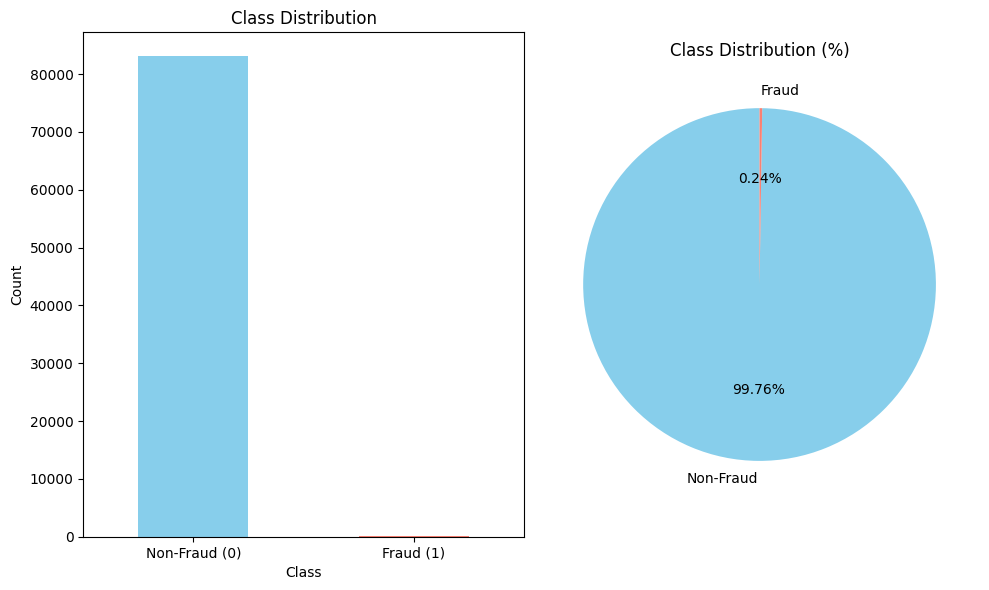

In [15]:
# Distribution of classes
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.ylabel('Count')

plt.subplot(1, 2, 2)
fraud_counts = df['Class'].value_counts()
plt.pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%',
        colors=['skyblue', 'salmon'], startangle=90)
plt.title('Class Distribution (%)')
plt.tight_layout()
plt.show()

In [17]:
# 3. DATA PREPROCESSING
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Verify no NaN in y
print(f"\nVerifying no NaN in target variable...")
print(f"NaN in y: {y.isnull().sum()}")
print(f"y dtype: {y.dtype}")
print(f"Unique values in y: {y.unique()}")


Verifying no NaN in target variable...
NaN in y: 0
y dtype: int64
Unique values in y: [0 1]


In [19]:
# Scale 'Time' and 'Amount' features
print("\nScaling 'Time' and 'Amount' features...")
scaler = RobustScaler()  # RobustScaler is less sensitive to outliers
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Split data into train and test sets (stratified to maintain class distribution)
print("\nSplitting data into train and test sets...")
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("✓ Train-test split successful!")
except ValueError as e:
    print(f"Error during train_test_split: {e}")
    print("Falling back to non-stratified split...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Fraud cases in training: {y_train.sum()} ({y_train.mean()*100:.3f}%)")
print(f"Fraud cases in test: {y_test.sum()} ({y_test.mean()*100:.3f}%)")


Scaling 'Time' and 'Amount' features...

Splitting data into train and test sets...
✓ Train-test split successful!

Training set shape: (66622, 30)
Test set shape: (16656, 30)
Fraud cases in training: 161 (0.242%)
Fraud cases in test: 40 (0.240%)


In [20]:
# 4. HANDLE CLASS IMBALANCE
print("\n" + "="*50)
print("HANDLING CLASS IMBALANCE")
print("="*50)

# We'll try different sampling strategies
sampling_strategies = [
    ('Original', 'none'),
    ('SMOTE', 'smote'),
    ('Undersampling', 'undersample')
]


HANDLING CLASS IMBALANCE


In [22]:
# 5. MODEL BUILDING
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Define models to try
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]) if len(y_train[y_train==1]) > 0 else 1,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}

In [25]:
# 6. EVALUATION METRICS FUNCTIONS
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, sampling_method='none'):
    """Evaluate model performance with appropriate metrics for imbalanced data"""

    # Apply sampling if specified
    if sampling_method == 'smote':
        try:
            smote = SMOTE(random_state=42, sampling_strategy=0.1)  # 10% fraud in training
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            print(f"  Applied SMOTE: {X_train_resampled.shape[0]} samples")
        except ValueError as e:
            print(f"  SMOTE failed: {e}. Using original data.")
            X_train_resampled, y_train_resampled = X_train, y_train
    elif sampling_method == 'undersample':
        try:
            rus = RandomUnderSampler(random_state=42, sampling_strategy=0.1)
            X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
            print(f"  Applied Undersampling: {X_train_resampled.shape[0]} samples")
        except Exception as e:
            print(f"  Undersampling failed: {e}. Using original data.")
            X_train_resampled, y_train_resampled = X_train, y_train
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    # Train model
    try:
        model.fit(X_train_resampled, y_train_resampled)
    except Exception as e:
        print(f"  Model training failed: {e}")
        return None

    # Predict probabilities and classes
    try:
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            # For models without predict_proba, use decision function
            y_pred_proba = model.decision_function(X_test)
            # Normalize to [0, 1]
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

        y_pred = model.predict(X_test)
    except Exception as e:
        print(f"  Prediction failed: {e}")
        return None

    # Calculate metrics
    try:
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
    except Exception as e:
        print(f"  Metric calculation failed: {e}")
        return None

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification Report
    report = classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud'], zero_division=0)

    return {
        'model_name': model_name,
        'sampling_method': sampling_method,
        'model': model,
        'auc_roc': auc_roc,
        'avg_precision': avg_precision,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm,
        'classification_report': report
    }

In [26]:
# 7. TRAIN AND EVALUATE MODELS
results = []
print("\nTraining and evaluating models...\n")

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"MODEL: {model_name}")
    print('='*60)

    for sampling_name, sampling_method in sampling_strategies:
        print(f"\nSampling: {sampling_name}")
        try:
            result = evaluate_model(
                model.__class__(**model.get_params()),  # Create fresh instance
                X_train, X_test, y_train, y_test,
                model_name, sampling_method
            )

            if result is not None:
                results.append(result)
                print(f"  AUC-ROC: {result['auc_roc']:.4f}")
                print(f"  Average Precision: {result['avg_precision']:.4f}")
                print(f"  F1-Score: {result['f1_score']:.4f}")
            else:
                print(f"  Evaluation failed for {model_name} with {sampling_name}")

        except Exception as e:
            print(f"  Error with {model_name} - {sampling_name}: {str(e)}")

# Check if we have any results
if not results:
    print("\nNo models were successfully trained. Please check your data and try again.")
    exit()


Training and evaluating models...


MODEL: Logistic Regression

Sampling: Original
  AUC-ROC: 0.9756
  Average Precision: 0.5266
  F1-Score: 0.2042

Sampling: SMOTE
  Applied SMOTE: 73107 samples
  AUC-ROC: 0.9778
  Average Precision: 0.5281
  F1-Score: 0.1905

Sampling: Undersampling
  Applied Undersampling: 1771 samples
  AUC-ROC: 0.9800
  Average Precision: 0.5074
  F1-Score: 0.1966

MODEL: Random Forest

Sampling: Original
  AUC-ROC: 0.9482
  Average Precision: 0.8288
  F1-Score: 0.8116

Sampling: SMOTE
  Applied SMOTE: 73107 samples
  AUC-ROC: 0.9822
  Average Precision: 0.8392
  F1-Score: 0.8451

Sampling: Undersampling
  Applied Undersampling: 1771 samples
  AUC-ROC: 0.9799
  Average Precision: 0.5563
  F1-Score: 0.7674

MODEL: XGBoost

Sampling: Original
  AUC-ROC: 0.9869
  Average Precision: 0.8467
  F1-Score: 0.8649

Sampling: SMOTE
  Applied SMOTE: 73107 samples
  AUC-ROC: 0.9911
  Average Precision: 0.8493
  F1-Score: 0.8250

Sampling: Undersampling
  Applied Undersampling

In [27]:
# 8. SELECT BEST MODEL BASED ON AVERAGE PRECISION (AUPRC)
print("\n" + "="*60)
print("MODEL COMPARISON - SORTED BY AVERAGE PRECISION (AUPRC)")
print("="*60)

# Create results dataframe
results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Sampling': r['sampling_method'],
    'AUC-ROC': r['auc_roc'],
    'Avg Precision': r['avg_precision'],
    'F1-Score': r['f1_score'],
    'Precision': r['precision'],
    'Recall': r['recall']
} for r in results])

# Sort by Average Precision (most important metric for imbalanced data)
results_df = results_df.sort_values('Avg Precision', ascending=False)
print(results_df.to_string(index=False))


MODEL COMPARISON - SORTED BY AVERAGE PRECISION (AUPRC)
              Model    Sampling  AUC-ROC  Avg Precision  F1-Score  Precision  Recall
  Gradient Boosting       smote 0.995373       0.885862  0.819277   0.790698   0.850
            XGBoost       smote 0.991117       0.849299  0.825000   0.825000   0.825
            XGBoost        none 0.986879       0.846732  0.864865   0.941176   0.800
      Random Forest       smote 0.982212       0.839239  0.845070   0.967742   0.750
      Random Forest        none 0.948218       0.828831  0.811594   0.965517   0.700
            XGBoost undersample 0.970576       0.690676  0.395349   0.257576   0.850
  Gradient Boosting undersample 0.990011       0.632486  0.628571   0.507692   0.825
  Gradient Boosting        none 0.952385       0.617812  0.743590   0.763158   0.725
      Random Forest undersample 0.979924       0.556288  0.767442   0.717391   0.825
Logistic Regression       smote 0.977756       0.528061  0.190476   0.107256   0.850
Logistic 

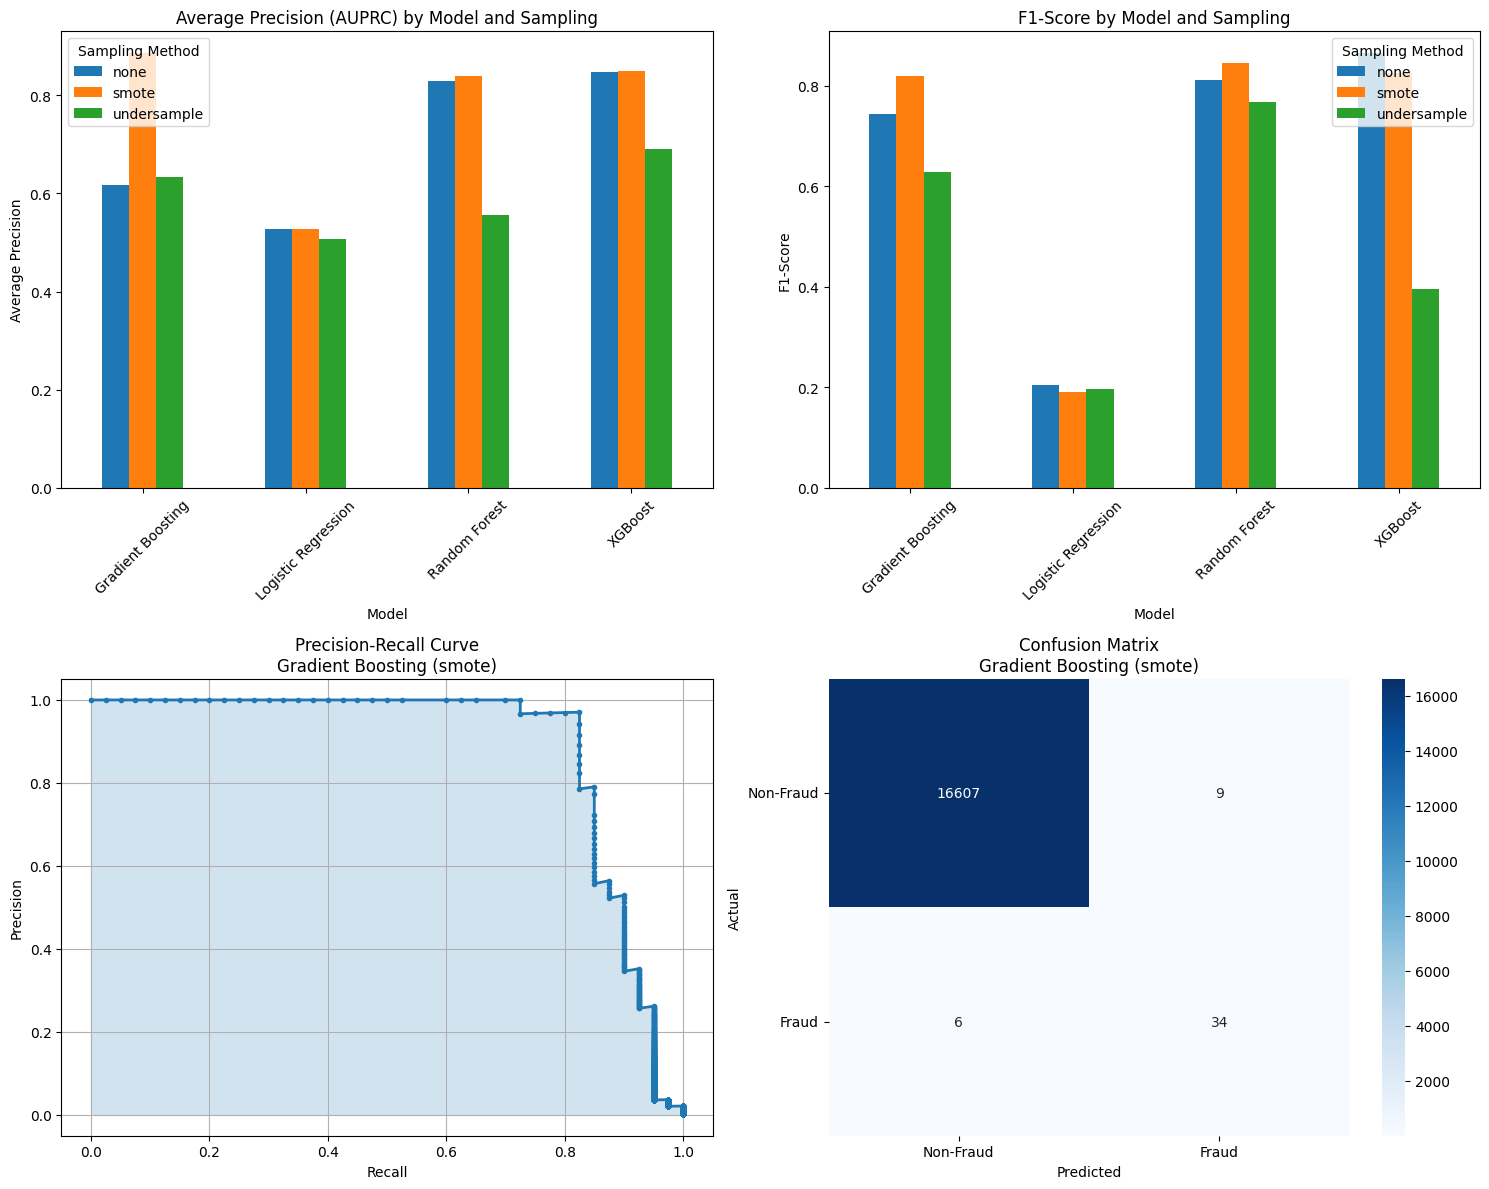

In [30]:
# 9. VISUALIZE RESULTS
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Average Precision comparison
if len(results_df['Model'].unique()) > 1:
    results_df_pivot = results_df.pivot(index='Model', columns='Sampling', values='Avg Precision')
    results_df_pivot.plot(kind='bar', ax=axes[0, 0])
else:
    axes[0, 0].bar(range(len(results_df)), results_df['Avg Precision'])
    axes[0, 0].set_xticks(range(len(results_df)))
    axes[0, 0].set_xticklabels([f"{row['Model']}-{row['Sampling']}" for _, row in results_df.iterrows()], rotation=45)
axes[0, 0].set_title('Average Precision (AUPRC) by Model and Sampling')
axes[0, 0].set_ylabel('Average Precision')
axes[0, 0].legend(title='Sampling Method')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: F1-Score comparison
if len(results_df['Model'].unique()) > 1:
    results_df_pivot_f1 = results_df.pivot(index='Model', columns='Sampling', values='F1-Score')
    results_df_pivot_f1.plot(kind='bar', ax=axes[0, 1])
else:
    axes[0, 1].bar(range(len(results_df)), results_df['F1-Score'])
    axes[0, 1].set_xticks(range(len(results_df)))
    axes[0, 1].set_xticklabels([f"{row['Model']}-{row['Sampling']}" for _, row in results_df.iterrows()], rotation=45)
axes[0, 1].set_title('F1-Score by Model and Sampling')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].legend(title='Sampling Method')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Precision-Recall tradeoff for best model
best_result = max(results, key=lambda x: x['avg_precision'])
try:
    precision_vals, recall_vals, _ = precision_recall_curve(
        y_test, best_result['model'].predict_proba(X_test)[:, 1]
    )
    axes[1, 0].plot(recall_vals, precision_vals, marker='.', linewidth=2)
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title(f'Precision-Recall Curve\n{best_result["model_name"]} ({best_result["sampling_method"]})')
    axes[1, 0].grid(True)
    axes[1, 0].fill_between(recall_vals, precision_vals, alpha=0.2)
except:
    axes[1, 0].text(0.5, 0.5, 'Precision-Recall curve\nnot available',
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Precision-Recall Curve')

# Plot 4: Confusion Matrix for best model
cm = best_result['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title(f'Confusion Matrix\n{best_result["model_name"]} ({best_result["sampling_method"]})')
axes[1, 1].set_xticklabels(['Non-Fraud', 'Fraud'])
axes[1, 1].set_yticklabels(['Non-Fraud', 'Fraud'], rotation=0)

plt.tight_layout()
plt.show()


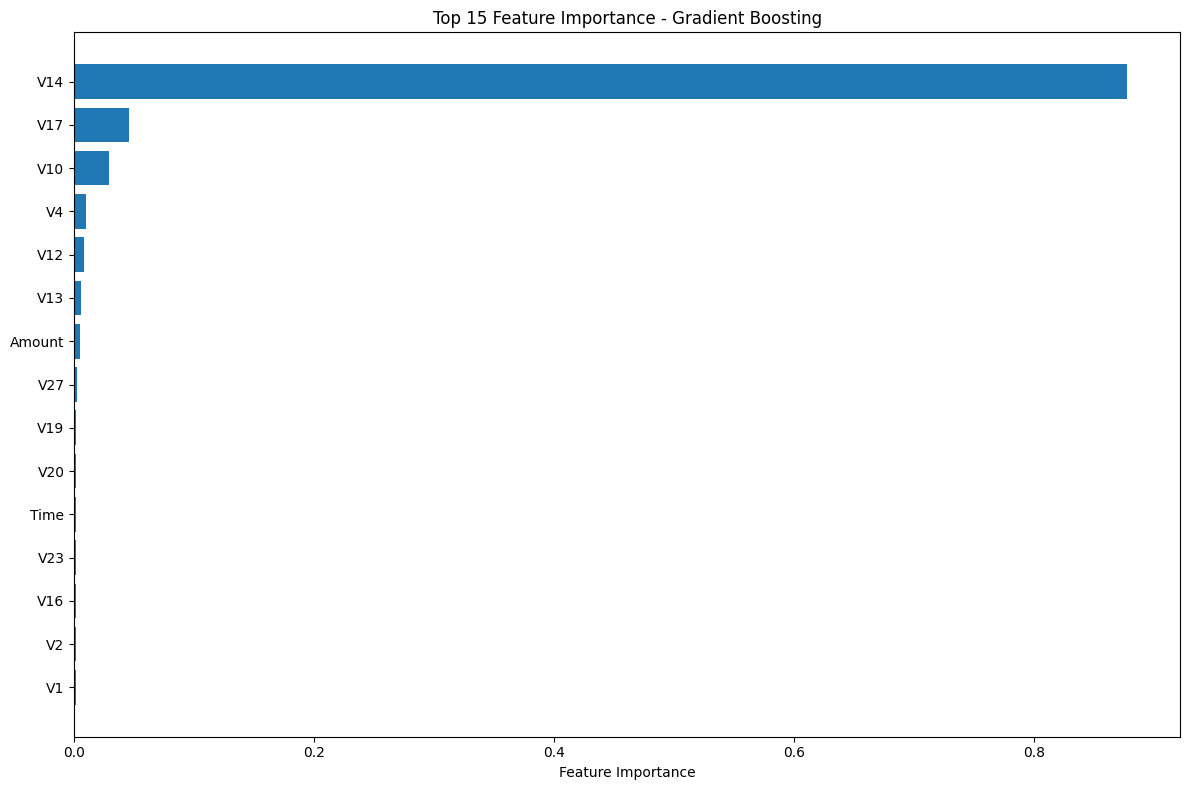

In [31]:
# 10. FEATURE IMPORTANCE (for tree-based models)
if hasattr(best_result['model'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_result['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_result["model_name"]}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [32]:
# 11. FINAL MODEL EVALUATION
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)

print(f"Best Model: {best_result['model_name']}")
print(f"Sampling Method: {best_result['sampling_method']}")
print(f"Average Precision (AUPRC): {best_result['avg_precision']:.4f}")
print(f"AUC-ROC: {best_result['auc_roc']:.4f}")
print(f"F1-Score: {best_result['f1_score']:.4f}")
print(f"Precision: {best_result['precision']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")

print("\nClassification Report:")
print(best_result['classification_report'])


FINAL MODEL PERFORMANCE
Best Model: Gradient Boosting
Sampling Method: smote
Average Precision (AUPRC): 0.8859
AUC-ROC: 0.9954
F1-Score: 0.8193
Precision: 0.7907
Recall: 0.8500

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     16616
       Fraud       0.79      0.85      0.82        40

    accuracy                           1.00     16656
   macro avg       0.90      0.92      0.91     16656
weighted avg       1.00      1.00      1.00     16656



In [33]:
# 12. THRESHOLD OPTIMIZATION
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

# Get predicted probabilities
try:
    if hasattr(best_result['model'], 'predict_proba'):
        y_pred_proba = best_result['model'].predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = best_result['model'].decision_function(X_test)
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

    # Try different thresholds
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        precision = precision_score(y_test, y_pred_threshold, zero_division=0)
        recall = recall_score(y_test, y_pred_threshold, zero_division=0)
        f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
        print(f"Threshold: {threshold:.1f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
except Exception as e:
    print(f"Threshold optimization failed: {e}")


THRESHOLD OPTIMIZATION
Threshold: 0.1 | Precision: 0.2846 | Recall: 0.9250 | F1: 0.4353
Threshold: 0.2 | Precision: 0.4932 | Recall: 0.9000 | F1: 0.6372
Threshold: 0.3 | Precision: 0.5965 | Recall: 0.8500 | F1: 0.7010
Threshold: 0.4 | Precision: 0.6538 | Recall: 0.8500 | F1: 0.7391
Threshold: 0.5 | Precision: 0.7907 | Recall: 0.8500 | F1: 0.8193
Threshold: 0.6 | Precision: 0.8250 | Recall: 0.8250 | F1: 0.8250
Threshold: 0.7 | Precision: 0.8462 | Recall: 0.8250 | F1: 0.8354
Threshold: 0.8 | Precision: 0.8919 | Recall: 0.8250 | F1: 0.8571
Threshold: 0.9 | Precision: 0.9706 | Recall: 0.8250 | F1: 0.8919


In [34]:
# 13. SAVE THE MODEL
import joblib

try:
    # Save the best model
    model_filename = 'best_fraud_detection_model.pkl'
    joblib.dump(best_result['model'], model_filename)
    print(f"\nModel saved as {model_filename}")

    # Save scaler
    scaler_filename = 'robust_scaler.pkl'
    joblib.dump(scaler, scaler_filename)
    print(f"Scaler saved as {scaler_filename}")
except Exception as e:
    print(f"\nFailed to save model: {e}")


Model saved as best_fraud_detection_model.pkl
Scaler saved as robust_scaler.pkl




**SUMMARY**
============================================================

Key steps performed:
1. Data cleaning (handled missing values, infinite values)
2. Exploratory Data Analysis
3. Feature scaling (RobustScaler for Time and Amount)
4. Train-test split (stratified when possible)
5. Class imbalance handling (SMOTE, Undersampling, Original)
6. Multiple model training and evaluation
7. Performance comparison using appropriate metrics
8. Model selection based on Average Precision (AUPRC)
9. Threshold optimization
10. Model saving and deployment function

For production deployment:
- Monitor model performance over time
- Implement retraining pipeline
- Set up alert system for model drift
- Consider ensemble methods for improved stability